In [1]:
import os
import pandas as pd
from wildlife_datasets import datasets
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets import splits
import torchvision.transforms as T
import timm
from wildlife_tools.features import *
from wildlife_tools.data import ImageDataset
from wildlife_tools.similarity import CosineSimilarity, MatchLOFTR, MatchLightGlue
from wildlife_tools.similarity.wildfusion import SimilarityPipeline, WildFusion
from wildlife_tools.similarity.calibration import IsotonicCalibration
import numpy as np
from wildlife_tools.inference import KnnClassifier
import matplotlib.pyplot as plt
from PIL import Image  
import pickle
import yaml

In [2]:
# --- Load Configuration ---
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
DATA_ROOT = os.path.expanduser(config['paths']['data_root'])
IMAGE_DIR = config['paths']['dataset_dir'].format(data_root=DATA_ROOT)
MANIFEST_FILE = config['paths']['merged_manifest_file'].format(data_root=DATA_ROOT)
CALIBRATION_DIR = config['paths']['calibration_dir'].format(data_root=DATA_ROOT) 

In [4]:
class Horses(datasets.WildlifeDataset):
    def create_catalogue(self) -> pd.DataFrame:
        """Create catalogue from manifest file"""
        # Read the manifest file
        manifest_df = pd.read_csv(MANIFEST_FILE)
        
        rows = []
        # Process each entry in the manifest
        for _, row in manifest_df.iterrows():
            # Skip if status is EXCLUDE or num_horses_detected is NONE or MULTIPLE
            if 'status' in row and row['status'] == 'EXCLUDE':
                continue
            if 'num_horses_detected' in row and row['num_horses_detected'] in ['NONE', 'MULTIPLE']:
                continue
            # Create a catalogue entry
            rows.append({
                'image_id': row['filename'],
                'identity': row['canonical_id'],
                'horse_name': row['horse_name'],
                'path': row['filename'],
                'date': pd.to_datetime(str(row['email_date']), format='%Y%m%d')  # Convert to datetime
            })
        
        # Create DataFrame from collected rows
        df = pd.DataFrame(rows)
        result = self.finalize_catalogue(df)
        return result

In [5]:
horses = Horses(IMAGE_DIR)
horses_df = horses.create_catalogue()

Number of identitites            168
Number of all animals            1268
Number of animals with one image 3
Number of unidentified animals   0
Images span                      2.6 years


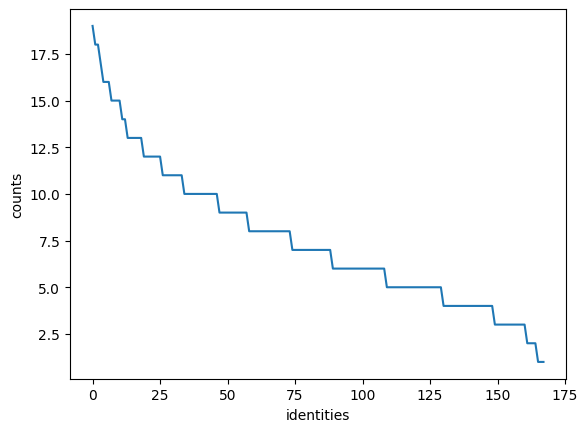

In [6]:
display_statistics(horses_df)

Figure(640x480)


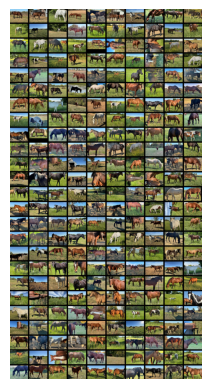

In [7]:
print(horses.plot_grid(n_rows=25, n_cols=10))

split the catalog into *training* and *testing* sets

In [8]:
splitter = splits.DisjointSetSplit(n_class_test=75)
for idx_train, idx_test in splitter.split(horses_df):
    splits.analyze_split(horses_df, idx_train, idx_test)

df_train = horses_df.loc[idx_train]
df_test = horses_df.loc[idx_test]

dataset_train = ImageDataset(df_train, horses.root)

Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 673/595/0/1268
Classes: train/test/unassigned/total = 93/75/0/168
Samples: train only/test only        = 673/595
Classes: train only/test only/joint  = 93/75/0

Fraction of train set     = 53.08%
Fraction of test set only = 46.92%


# Training

In [9]:
matchers = {

    'lightglue_superpoint': SimilarityPipeline(
        matcher = MatchLightGlue(features='superpoint'),
        extractor = SuperPointExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_aliked': SimilarityPipeline(
        matcher = MatchLightGlue(features='aliked'),
        extractor = AlikedExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_disk': SimilarityPipeline(
        matcher = MatchLightGlue(features='disk'),
        extractor = DiskExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    'lightglue_sift': SimilarityPipeline(
        matcher = MatchLightGlue(features='sift'),
        extractor = SiftExtractor(),
        transform = T.Compose([
            T.Resize([512, 512]),
            T.ToTensor()
        ]),
        calibration = IsotonicCalibration()
    ),

    # SimilarityPipeline(
    #     matcher = MatchLOFTR(pretrained='outdoor'),
    #     extractor = None,
    #     transform = T.Compose([
    #         T.Resize([512, 512]),
    #         T.Grayscale(),
    #         T.ToTensor(),
    #     ]),
    #     calibration = IsotonicCalibration()
    # ),

    # 'wildlife-mega-L-384': SimilarityPipeline(
    #     matcher = CosineSimilarity(),
    #     extractor = DeepFeatures(
    #         model = timm.create_model(
    #           'hf-hub:BVRA/wildlife-mega-L-384',
    #           num_classes=0,
    #           pretrained=True
    #           )
    #     ),
    #     transform = T.Compose([
    #         T.Resize(size=(384, 384)),
    #         T.ToTensor(),
    #         T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #     ]),
    #     calibration = IsotonicCalibration()
    # ),
}

priority_matcher =  SimilarityPipeline(
    matcher = CosineSimilarity(),
    extractor = DeepFeatures(
        model = timm.create_model(
        'hf-hub:BVRA/wildlife-mega-L-384',
        num_classes=0,
        pretrained=True
        )
    ),
    transform = T.Compose([
        T.Resize(size=(384, 384)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]),
)




/Users/dleigh/git/dlleigh/horse-id/.venv/lib/python3.13/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [10]:
# Create calibration directory if it doesn't exist
os.makedirs(CALIBRATION_DIR, exist_ok=True)

# Check for existing calibrations and load them
print("Checking for existing calibrations...")
all_loaded = True
for name, matcher in matchers.items():
    cal_file = f"{CALIBRATION_DIR}/{name}.pkl"
    if os.path.exists(cal_file):
        print(f"Loading calibration: {cal_file}")
        try:
            with open(cal_file, 'rb') as f:
                matcher.calibration = pickle.load(f)
                matcher.calibration_done = True  # Set the flag after successful load
        except Exception as e:
            print(f"Error loading calibration {cal_file}: {e}")
            all_loaded = False
    else:
        print(f"Missing calibration: {cal_file}")
        all_loaded = False

wildfusion = WildFusion(calibrated_pipelines = list(matchers.values()), priority_pipeline= priority_matcher)

if not all_loaded:
    print("\nFitting new calibrations...")
    wildfusion.fit_calibration(dataset_train, dataset_train)
    
    # Save calibrations
    print("\nSaving calibrations...")
    for name, matcher in matchers.items():
        cal_file = f"{CALIBRATION_DIR}/{name}.pkl"
        try:
            with open(cal_file, 'wb') as f:
                pickle.dump(matcher.calibration, f)
            print(f"Saved: {cal_file}")
        except Exception as e:
            print(f"Error saving calibration {cal_file}: {e}")
else:
    print("\nAll calibrations loaded successfully")

Checking for existing calibrations...
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_superpoint.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_aliked.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_disk.pkl
Loading calibration: /Users/dleigh/google-drive/horseID Project/data/calibrations/lightglue_sift.pkl

All calibrations loaded successfully


# Testing

Split the testing dataset into *query* and *database* sets

In [11]:
splitter = splits.ClosedSetSplit(0.2)
for idx_query, idx_database in splitter.split(df_test):
    splits.analyze_split(df_test, idx_query, idx_database)
    
df_query = df_test.loc[idx_query]
df_database = df_test.loc[idx_database]

dataset_query = ImageDataset(df_query, horses.root)
dataset_database = ImageDataset(df_database, horses.root)

Split: time-unaware closed-set
Samples: train/test/unassigned/total = 122/473/0/595
Classes: train/test/unassigned/total = 75/75/0/75
Samples: train only/test only        = 0/0
Classes: train only/test only/joint  = 0/0/75

Fraction of train set     = 20.50%
Fraction of test set only = 0.00%


In [ ]:
similarity = wildfusion(dataset_query, dataset_database, B=20)

100%|███████████████████████████████████████████████████████████████| 29/29 [01:16<00:00,  2.65s/it]


## Evaluate

In [25]:
classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
predictions = classifier(similarity)
accuracy = np.mean(dataset_query.labels_string == predictions)

In [26]:
accuracy

np.float64(0.9098360655737705)

In [27]:
def display_predictions(test_df, train_df, predictions, output_path, num_samples=None):
    # If num_samples not specified, show all but limit to 50 samples to avoid size issues
    if num_samples is None:
        num_samples = min(len(test_df), 50)  # Limit to 50 samples
    else:
        num_samples = min(num_samples, len(test_df), 50)
    
    # Calculate figure size with limitations
    width = 10  # Fixed width
    height_per_row = 4
    max_height = 65000 / plt.rcParams['figure.dpi']  # Maximum height in inches
    total_height = min(height_per_row * num_samples, max_height)
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(width, total_height))
    
    # Handle case where there's only one sample
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(num_samples):
        # Get test image path and predicted horse
        test_path = os.path.join(horses.root, test_df.iloc[idx]['path'])
        pred_horse = int(str(predictions[idx]))
        
        # Find the first image of the predicted horse in training set
        pred_image_path = os.path.join(horses.root, 
            train_df[train_df['identity'] == pred_horse].iloc[0]['path'])
        
        test_name = test_df.iloc[idx]['horse_name']
        pred_name = train_df[train_df['identity'] == pred_horse].iloc[0]['horse_name']
        # Load and display test image
        test_img = Image.open(test_path)
        axes[idx, 0].imshow(test_img)
        axes[idx, 0].set_xticks([])
        axes[idx, 0].set_yticks([])
        axes[idx, 0].set_title(f"Test Image\nActual: {test_name}")
        
        # Load and display predicted match
        pred_img = Image.open(pred_image_path)
        axes[idx, 1].imshow(pred_img)
        axes[idx, 1].set_xticks([])
        axes[idx, 1].set_yticks([])
        axes[idx, 1].set_title(f"Predicted Match\nPredicted: {pred_name}")
        
        # Add color coding for correct/incorrect predictions
        color = 'green' if test_df.iloc[idx]['identity'] == pred_horse else 'red'
        for ax in axes[idx]:
            for spine in ax.spines.values():
                spine.set_color(color)
                spine.set_linewidth(5)
    
    plt.tight_layout()
    
    # Save with reduced DPI if the file would be too large
    try:
        plt.savefig(output_path, format='jpg', dpi=300, bbox_inches='tight')
    except ValueError:
        print("Warning: Reducing DPI to 150 due to image size limitations")
        plt.savefig(output_path, format='jpg', dpi=150, bbox_inches='tight')
    plt.close('all')  # Always close all figures

In [28]:

# Save predictions to file
output_path = "prediction-results.jpg"
display_predictions(df_query, df_database, predictions, output_path, num_samples=len(predictions))
print(f"Prediction results saved to: {output_path}")

Prediction results saved to: prediction-results.jpg
